<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_ozawa/DeepXplore/DeepXplore_04_01_result_01_20200209_0046_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス

#import datetime
#import pytz
#dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
#dt_str = str(dt_now.strftime('%Y%m%d_%H%M'))
dt_str = "20200209_0046"

data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
#data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_mnist = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/MNIST"
#data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
#output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output/" + dt_str
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"

In [2]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
import argparse
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

%tensorflow_version 1.x
from keras.datasets import mnist
from keras.layers import Input
import imageio

from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, Input, Dense, Activation, Flatten
from keras.models import Model
from keras.utils import to_categorical
import os

# TensorFlowでGPUを使っているかのチェック：
# "device_type: "GPU" " があればOK
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6611125867803467978, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6193209994064274913
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(0, 0), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(10, 10), type=tuple)
noise_type = "light" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.1" #@param {type:"string"}
step = "10" #@param {type:"string"}　#50だとほぼ白飛び
seeds = "10" #@param {type:"string"}
grad_iterations = "20" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

length = int(args.seeds)

df2_scale = pd.DataFrame()
df3_scale = pd.DataFrame()
df4_scale = pd.DataFrame()
for start_fig in range(10):
  #df1_scale = pd.read_csv(output_dir[:-14]+ "/01_fig" + str(start_fig) + "_seed" + str(length) +"_neuron.csv")
  df1_scale = pd.read_csv(output_dir + "/03_16_fig" + str(start_fig) + "_seed" + str(length) +"_neuron.csv")
  df2_scale = pd.concat([df2_scale, df1_scale])

  #df1_scale = pd.read_csv(output_dir[:-14]+ "/01_fig" + str(start_fig) + "_seed" + str(length) +"_index.csv")
  df1_scale = pd.read_csv(output_dir + "/03_16_fig" + str(start_fig) + "_seed" + str(length) +"_index.csv")
  df3_scale = pd.concat([df3_scale, df1_scale])

  #df1_scale = pd.read_csv(output_dir[:-14]+ "/01_fig" + str(start_fig) + "_seed" + str(length) +"_trace.csv")
  df1_scale = pd.read_csv(output_dir + "/03_16_fig" + str(start_fig) + "_seed" + str(length) +"_trace.csv")
  df4_scale = pd.concat([df4_scale, df1_scale])

tmp_list = list(df2_scale.iloc[:,0])
df2_scale.index = tmp_list
print(df2_scale.iloc[:,1:].head())

tmp_list = list(df3_scale.iloc[:,0])
df3_scale.index = tmp_list
print(df3_scale.iloc[:,1:].head())

tmp_list = list(df4_scale.iloc[:,0])
df4_scale.index = tmp_list
print(df4_scale.iloc[:,1:].head())

     ('block1_conv1', 0)  ...  ('predictions', 9)
0_1                0.005  ...               0.000
0_2                0.540  ...               0.000
0_3                0.357  ...               0.000
0_4                0.387  ...               0.000
0_5                0.537  ...               0.000

[5 rows x 52 columns]
     already_diff  found  not_found  ... index2        layer3  index3
0_1         0.000  4.000      0.000  ...  2.000           fc2  12.000
0_2         0.000  6.000      0.000  ... 79.000           fc1  89.000
0_3         0.000  0.000      1.000  ... 72.000  block2_conv1  14.000
0_4         0.000  0.000      1.000  ...  8.000           fc2  63.000
0_5         0.000  2.000      0.000  ...  4.000           fc1 116.000

[5 rows x 9 columns]
       ('block1_conv1', 0)  ...  ('predictions', 9)
0_1_0                0.084  ...               0.001
0_1_1                0.479  ...               0.000
0_1_2                0.228  ...               0.000
0_1_3                0.005 

In [5]:
df4_scale.head(6)

,Unnamed: 0,"('block1_conv1', 0)","('block1_conv1', 1)","('block1_conv1', 2)","('block1_conv1', 3)","('block1_pool1', 0)","('block1_pool1', 1)","('block1_pool1', 2)","('block1_pool1', 3)","('block2_conv1', 0)","('block2_conv1', 1)","('block2_conv1', 2)","('block2_conv1', 3)","('block2_conv1', 4)","('block2_conv1', 5)","('block2_conv1', 6)","('block2_conv1', 7)","('block2_conv1', 8)","('block2_conv1', 9)","('block2_conv1', 10)","('block2_conv1', 11)","('block2_pool1', 0)","('block2_pool1', 1)","('block2_pool1', 2)","('block2_pool1', 3)","('block2_pool1', 4)","('block2_pool1', 5)","('block2_pool1', 6)","('block2_pool1', 7)","('block2_pool1', 8)","('block2_pool1', 9)","('block2_pool1', 10)","('block2_pool1', 11)","('before_softmax', 0)","('before_softmax', 1)","('before_softmax', 2)","('before_softmax', 3)","('before_softmax', 4)","('before_softmax', 5)","('before_softmax', 6)","('before_softmax', 7)","('before_softmax', 8)","('before_softmax', 9)","('predictions', 0)","('predictions', 1)","('predictions', 2)","('predictions', 3)","('predictions', 4)","('predictions', 5)","('predictions', 6)","('predictions', 7)","('predictions', 8)","('predictions', 9)"
0_1_0,0_1_0,0.084,0.073,0.086,0.073,0.126,0.112,0.135,0.112,0.065,0.101,0.080,0.060,0.079,0.098,0.070,0.064,0.064,0.087,0.048,0.064,0.130,0.203,0.161,0.111,0.161,0.182,0.134,0.101,0.132,0.173,0.103,0.130,1.000,0.000,0.450,0.142,0.175,0.508,0.495,0.204,0.044,0.393,1.000,0.000,0.001,0.000,0.000,0.002,0.002,0.000,0.000,0.001
0_1_1,0_1_1,0.479,0.309,0.075,0.344,0.520,0.345,0.098,0.381,0.228,0.088,0.022,0.264,0.156,0.166,0.072,0.155,0.029,0.056,0.018,0.163,0.338,0.159,0.044,0.348,0.260,0.270,0.121,0.220,0.061,0.110,0.035,0.242,1.000,0.000,0.820,0.718,0.136,0.527,0.433,0.173,0.597,0.188,1.000,0.000,0.019,0.002,0.000,0.000,0.000,0.000,0.000,0.000
0_1_2,0_1_2,0.228,0.144,0.057,0.161,0.279,0.186,0.085,0.204,0.102,0.097,0.049,0.100,0.098,0.114,0.060,0.093,0.044,0.072,0.032,0.085,0.171,0.184,0.106,0.156,0.179,0.202,0.108,0.146,0.090,0.141,0.063,0.148,1.000,0.000,0.557,0.351,0.115,0.432,0.457,0.196,0.276,0.339,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0_1_3,0_1_3,0.005,0.008,0.100,0.006,0.012,0.019,0.161,0.013,0.032,0.094,0.104,0.057,0.064,0.084,0.089,0.021,0.091,0.128,0.093,0.038,0.064,0.192,0.193,0.099,0.137,0.154,0.153,0.041,0.167,0.248,0.165,0.077,1.000,0.233,0.635,0.000,0.838,0.756,0.865,0.367,0.405,0.585,1.000,0.007,0.106,0.000,0.372,0.224,0.437,0.019,0.024,0.077
0_2_0,0_2_0,0.134,0.090,0.060,0.097,0.188,0.136,0.092,0.138,0.084,0.103,0.069,0.073,0.101,0.106,0.062,0.090,0.067,0.080,0.043,0.075,0.137,0.188,0.136,0.127,0.160,0.191,0.123,0.187,0.121,0.152,0.085,0.146,1.000,0.000,0.598,0.376,0.039,0.554,0.473,0.121,0.506,0.262,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0_2_1,0_2_1,0.508,0.329,0.078,0.365,0.551,0.366,0.102,0.401,0.205,0.071,0.016,0.235,0.145,0.139,0.062,0.143,0.025,0.041,0.015,0.143,0.296,0.117,0.039,0.305,0.224,0.219,0.109,0.229,0.052,0.077,0.029,0.209,1.000,0.024,0.939,0.864,0.009,0.643,0.396,0.000,0.803,0.120,1.000,0.000,0.232,0.038,0.000,0.000,0.000,0.000,0.009,0.000


### [前]
* ある誤判断が起こった画像に対する発火値の抽出
* もともとの画像と、バグが起きた時の画像




In [6]:
print(df4_scale.loc["2_7_0"][:4])
print(type(df4_scale.loc["2_7_0"]))
print(type(df4_scale.loc["2_7_0":"2_7_2"]))
print(df4_scale.loc["2_7_0"][1])
print(type(df4_scale.loc["2_7_0"][1]))

print(df4_scale.loc["2_7_0"].index[1])

Unnamed: 0             2_7_0
('block1_conv1', 0)    0.095
('block1_conv1', 1)    0.064
('block1_conv1', 2)    0.048
Name: 2_7_0, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
0.09514566510915756
<class 'numpy.float64'>
('block1_conv1', 0)


### [後]
* すべてのご判断が起こった画像の抽出　＋　各々に対する発火値の相関の抽出
* もともとの画像と、バグが起きた時の画像のチョイス

In [7]:
df3_scale.head(6)

,Unnamed: 0,already_diff,found,not_found,layer1,index1,layer2,index2,layer3,index3
0_1,0_1,0.000,4.000,0.000,block2_conv1,10.000,fc1,2.000,fc2,12.000
0_2,0_2,0.000,6.000,0.000,block2_pool1,3.000,fc1,79.000,fc1,89.000
0_3,0_3,0.000,0.000,1.000,predictions,1.000,fc1,72.000,block2_conv1,14.000
0_4,0_4,0.000,0.000,1.000,predictions,8.000,block2_conv1,8.000,fc2,63.000
0_5,0_5,0.000,2.000,0.000,block1_conv1,2.000,fc1,4.000,fc1,116.000
0_6,0_6,0.000,0.000,1.000,predictions,8.000,fc1,67.000,fc1,70.000


In [37]:
target_list = []
target0_list = []
target1_list = []
for index in df3_scale.index:
  #print( df3_scale.loc[index])
  #print( df3_scale.loc[index]["found"])
  found = df3_scale.loc[index]["found"]

  if found > 2.5:
    #print(index, int(df3_scale.loc[index]["found"]))
    test_name = index
    test_name0 = index + "_0"
    test_name1 = index + "_" + str(int(df3_scale.loc[index]["found"])-1)
    #test_name1 = index + "_" + str(int(df3_scale.loc[index]["found"]))
    #print(index, test_name1)
    target_list.append(test_name)
    target0_list.append(test_name0)
    target1_list.append(test_name1)

print(target_list)
print(target0_list)
print(target1_list)
print(len(target1_list))
print(len(target0_list))


['0_1', '0_2', '0_9', '0_10', '1_1', '1_3', '1_4', '1_5', '1_6', '1_7', '2_5', '2_7', '2_9', '3_3', '3_7', '4_2', '4_3', '4_5', '4_10', '5_4', '5_5', '6_2', '6_9', '7_1', '7_2', '7_3', '7_7', '7_9', '8_4', '8_5', '8_9', '9_1', '9_3', '9_8']
['0_1_0', '0_2_0', '0_9_0', '0_10_0', '1_1_0', '1_3_0', '1_4_0', '1_5_0', '1_6_0', '1_7_0', '2_5_0', '2_7_0', '2_9_0', '3_3_0', '3_7_0', '4_2_0', '4_3_0', '4_5_0', '4_10_0', '5_4_0', '5_5_0', '6_2_0', '6_9_0', '7_1_0', '7_2_0', '7_3_0', '7_7_0', '7_9_0', '8_4_0', '8_5_0', '8_9_0', '9_1_0', '9_3_0', '9_8_0']
['0_1_3', '0_2_5', '0_9_9', '0_10_2', '1_1_2', '1_3_2', '1_4_2', '1_5_2', '1_6_2', '1_7_2', '2_5_2', '2_7_2', '2_9_45', '3_3_38', '3_7_9', '4_2_2', '4_3_2', '4_5_5', '4_10_3', '5_4_3', '5_5_2', '6_2_4', '6_9_4', '7_1_15', '7_2_5', '7_3_2', '7_7_2', '7_9_2', '8_4_4', '8_5_17', '8_9_3', '9_1_2', '9_3_2', '9_8_2']
34
34


In [38]:
test = 0
df4_scale.loc[target0_list[test]:target1_list[test]].iloc[:,1:]

,"('block1_conv1', 0)","('block1_conv1', 1)","('block1_conv1', 2)","('block1_conv1', 3)","('block1_pool1', 0)","('block1_pool1', 1)","('block1_pool1', 2)","('block1_pool1', 3)","('block2_conv1', 0)","('block2_conv1', 1)","('block2_conv1', 2)","('block2_conv1', 3)","('block2_conv1', 4)","('block2_conv1', 5)","('block2_conv1', 6)","('block2_conv1', 7)","('block2_conv1', 8)","('block2_conv1', 9)","('block2_conv1', 10)","('block2_conv1', 11)","('block2_pool1', 0)","('block2_pool1', 1)","('block2_pool1', 2)","('block2_pool1', 3)","('block2_pool1', 4)","('block2_pool1', 5)","('block2_pool1', 6)","('block2_pool1', 7)","('block2_pool1', 8)","('block2_pool1', 9)","('block2_pool1', 10)","('block2_pool1', 11)","('before_softmax', 0)","('before_softmax', 1)","('before_softmax', 2)","('before_softmax', 3)","('before_softmax', 4)","('before_softmax', 5)","('before_softmax', 6)","('before_softmax', 7)","('before_softmax', 8)","('before_softmax', 9)","('predictions', 0)","('predictions', 1)","('predictions', 2)","('predictions', 3)","('predictions', 4)","('predictions', 5)","('predictions', 6)","('predictions', 7)","('predictions', 8)","('predictions', 9)"
0_1_0,0.084,0.073,0.086,0.073,0.126,0.112,0.135,0.112,0.065,0.101,0.080,0.060,0.079,0.098,0.070,0.064,0.064,0.087,0.048,0.064,0.130,0.203,0.161,0.111,0.161,0.182,0.134,0.101,0.132,0.173,0.103,0.130,1.000,0.000,0.450,0.142,0.175,0.508,0.495,0.204,0.044,0.393,1.000,0.000,0.001,0.000,0.000,0.002,0.002,0.000,0.000,0.001
0_1_1,0.479,0.309,0.075,0.344,0.520,0.345,0.098,0.381,0.228,0.088,0.022,0.264,0.156,0.166,0.072,0.155,0.029,0.056,0.018,0.163,0.338,0.159,0.044,0.348,0.260,0.270,0.121,0.220,0.061,0.110,0.035,0.242,1.000,0.000,0.820,0.718,0.136,0.527,0.433,0.173,0.597,0.188,1.000,0.000,0.019,0.002,0.000,0.000,0.000,0.000,0.000,0.000
0_1_2,0.228,0.144,0.057,0.161,0.279,0.186,0.085,0.204,0.102,0.097,0.049,0.100,0.098,0.114,0.060,0.093,0.044,0.072,0.032,0.085,0.171,0.184,0.106,0.156,0.179,0.202,0.108,0.146,0.090,0.141,0.063,0.148,1.000,0.000,0.557,0.351,0.115,0.432,0.457,0.196,0.276,0.339,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0_1_3,0.005,0.008,0.100,0.006,0.012,0.019,0.161,0.013,0.032,0.094,0.104,0.057,0.064,0.084,0.089,0.021,0.091,0.128,0.093,0.038,0.064,0.192,0.193,0.099,0.137,0.154,0.153,0.041,0.167,0.248,0.165,0.077,1.000,0.233,0.635,0.000,0.838,0.756,0.865,0.367,0.405,0.585,1.000,0.007,0.106,0.000,0.372,0.224,0.437,0.019,0.024,0.077


In [0]:
#df4_scale.loc[target1]

In [138]:
%%time
import glob
import re
df5_scale = pd.DataFrame(columns=df4_scale.columns[1:])

for i in range(len(target1_list)):
  target = target0_list[i]
  target0 = target0_list[i]
  target1 = target1_list[i]

  test = [m.span() for m in re.finditer('_', target1_list[i])]
  trial = int(target1_list[i][test[0][1]:test[1][0]]) - 1
 
  file_list = glob.glob(output_dir + "/light_from" + target1_list[i][0] + "*" + str(trial) + "].png")
  #print("error", file_list[0][file_list[0].find("_to")+3], file_list[0])
  error_before= target[0]
  error_after = file_list[0][file_list[0].find("_to")+3]

  if error_before != error_after:
   #print("#", i, file_list, "error from", target[0], "to", error_after)
    df = df4_scale.loc[target0:target1].iloc[:,1:]
    df_corr = df.corr()
    print("#", i, "('predictions', "+error_after+")")
    #print(df_corr["('predictions', "+error_after+")"] > 0.80)+(df_corr["('predictions', "+error_after+")"] < -0.80)
    #print(type(df_corr["('predictions', "+error_after+")"] > 0.8))
    temp = (df_corr["('predictions', "+error_after+")"] > 0.8)
    df5_scale = df5_scale.append(temp)
    temp = (df_corr["('predictions', "+error_after+")"] < -0.8)
    df5_scale = df5_scale.append(temp)
  
df.head()

# 1 ('predictions', 2)
# 3 ('predictions', 3)
# 4 ('predictions', 3)
# 5 ('predictions', 3)
# 6 ('predictions', 3)
# 7 ('predictions', 3)
# 8 ('predictions', 3)
# 9 ('predictions', 3)
# 11 ('predictions', 7)
# 12 ('predictions', 7)
# 13 ('predictions', 5)
# 14 ('predictions', 5)
# 15 ('predictions', 8)
# 16 ('predictions', 3)
# 17 ('predictions', 3)
# 18 ('predictions', 3)
# 19 ('predictions', 3)
# 20 ('predictions', 4)
# 21 ('predictions', 3)
# 22 ('predictions', 3)
# 23 ('predictions', 3)
# 24 ('predictions', 3)
# 25 ('predictions', 3)
# 26 ('predictions', 3)
# 27 ('predictions', 3)
# 31 ('predictions', 3)
# 32 ('predictions', 4)
# 33 ('predictions', 1)
CPU times: user 186 ms, sys: 8.45 ms, total: 194 ms
Wall time: 205 ms


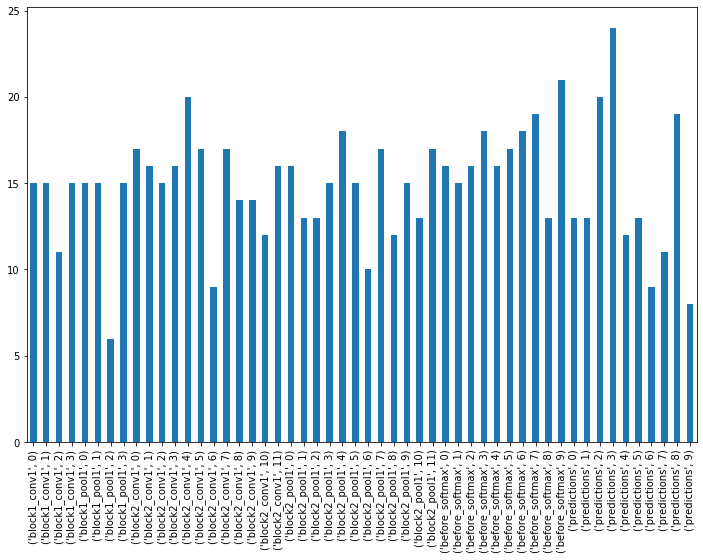

In [139]:
fig, axes = plt.subplots(figsize=(12, 8))
df5_scale.sum().plot(kind = "bar")

できた。

[前]もともとの画像と、バグが起きた時の画像

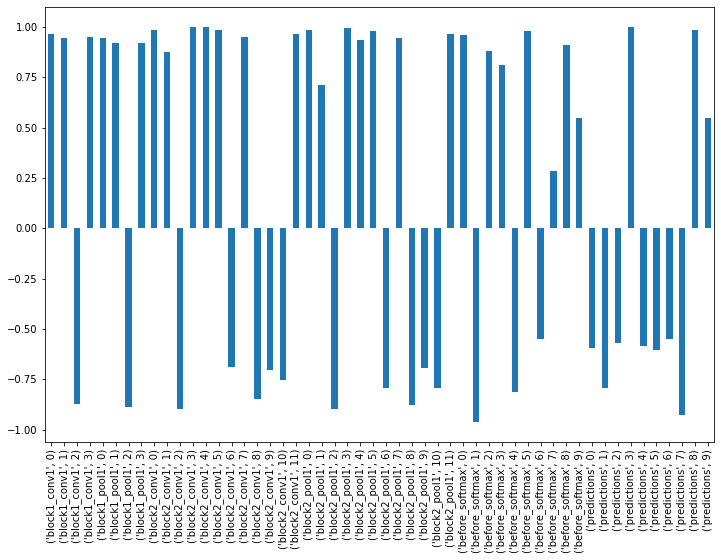

In [42]:
import matplotlib.pyplot as plt

df_corr = df.corr()

#fig, axes = plt.subplots(figsize=(12, 16))
#df_corr[["('predictions', 3)","('before_softmax', 7)"]].plot(kind="bar")
fig, axes = plt.subplots(figsize=(12, 8))
df_corr["('predictions', 3)"].plot(kind="bar")

[後]もともとの画像と、バグが起きた時の画像のチョイス

In [0]:
orig_fig_list = []

for i in target0_list:
  orig_fig_list.append(i[0])
  test = [m.span() for m in re.finditer('_', i)]
  orig_fig_list.append(i[test[0][1]:test[1][0]])


In [61]:
i = "9_100_10"
#orig_fig_list
print(i, i.find("_"))

9_100_10 1


In [62]:
import re
print([m.span() for m in re.finditer('_', i)])

[(1, 2), (5, 6)]


In [66]:
test = [m.span() for m in re.finditer('_', i)]
test

[(1, 2), (5, 6)]

In [67]:
print(test[0][1], test[1][0])

2 5


In [68]:
i[test[0][1]:test[1][0]]

'100'

In [78]:
import glob
file_list = glob.glob(output_dir + "/light_from*].png")
test = 2
print(file_list[test])
print(file_list[test][file_list[test].find("_to")+3], file_list[test])

/content/gdrive/My Drive/ColabNotebooks/test4ai/output/20200209_0046/light_from0_to3_0_2_[4].png
3 /content/gdrive/My Drive/ColabNotebooks/test4ai/output/20200209_0046/light_from0_to3_0_2_[4].png


In [13]:
#target0 = "2_7_0"
#target1 = "2_7_2"
target0 = "7_1_1"
target1 = "7_1_15"
print(df4_scale.loc[target0:target1, "('block1_conv1', 0)":"('block1_conv1', 3)"])
print(df4_scale.loc[target0:target1:2, "('block1_conv1', 0)":"('block1_conv1', 3)"])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
#df4_scale.loc[target0:target1, "('block1_conv1', 0)":"('block1_conv1', 3)"].plot(kind="barh")
df4_scale.loc[target0:target1:2, "('block1_conv1', 0)":"('block1_conv1', 3)" ].plot(ax=axes[0, 0], kind="line")
df4_scale.loc[target0:target1:2, "('block1_pool1', 0)":"('block1_pool1', 3)" ].plot(ax=axes[0, 1], kind="line")
df4_scale.loc[target0:target1:2, "('block2_conv1', 0)":"('block2_conv1', 11)"].plot(ax=axes[1, 0], kind="line")
df4_scale.loc[target0:target1:2, "('block2_pool1', 0)":"('block2_pool1', 11)"].plot(ax=axes[1, 1], kind="line")
df4_scale.loc[target0:target1:2, "('before_softmax', 0)":"('before_softmax', 9)"].plot(ax=axes[2, 0], kind="line")
df4_scale.loc[target0:target1:2, "('predictions', 0)":"('predictions', 9)"].plot(ax=axes[2, 1], kind="line")
#df4_scale.loc[target1][1:5].plot(kind="bar")


        ('block1_conv1', 0)  ...  ('block1_conv1', 3)
7_1_1                 0.352  ...                0.251
7_1_2                 0.003  ...                0.004
7_1_3                 0.179  ...                0.125
7_1_4                 0.001  ...                0.002
7_1_5                 0.271  ...                0.192
7_1_6                 0.000  ...                0.000
7_1_7                 0.239  ...                0.169
7_1_8                 0.000  ...                0.000
7_1_9                 0.152  ...                0.105
7_1_10                0.010  ...                0.012
7_1_11                0.380  ...                0.272
7_1_12                0.010  ...                0.012
7_1_13                0.387  ...                0.277
7_1_14                0.016  ...                0.018
7_1_15                0.417  ...                0.299

[15 rows x 4 columns]
        ('block1_conv1', 0)  ...  ('block1_conv1', 3)
7_1_1                 0.352  ...                0.251
7_1_3

NameError: ignored

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))
plt.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=18)
#df4_scale.loc[target0:target1, "('block1_conv1', 0)":"('block1_conv1', 3)"].plot(kind="barh")
df4_scale.loc[target0:target1:2, "('block1_conv1', 0)":"('block1_conv1', 3)" ].plot(ax=axes[0, 0], kind="line")
df4_scale.loc[target0:target1, "('block1_conv1', 0)":"('block1_conv1', 3)" ].plot(ax=axes[0, 1], kind="line")


In [0]:
df = df4_scale.loc[target0:target1:2].iloc[:,1:]
df

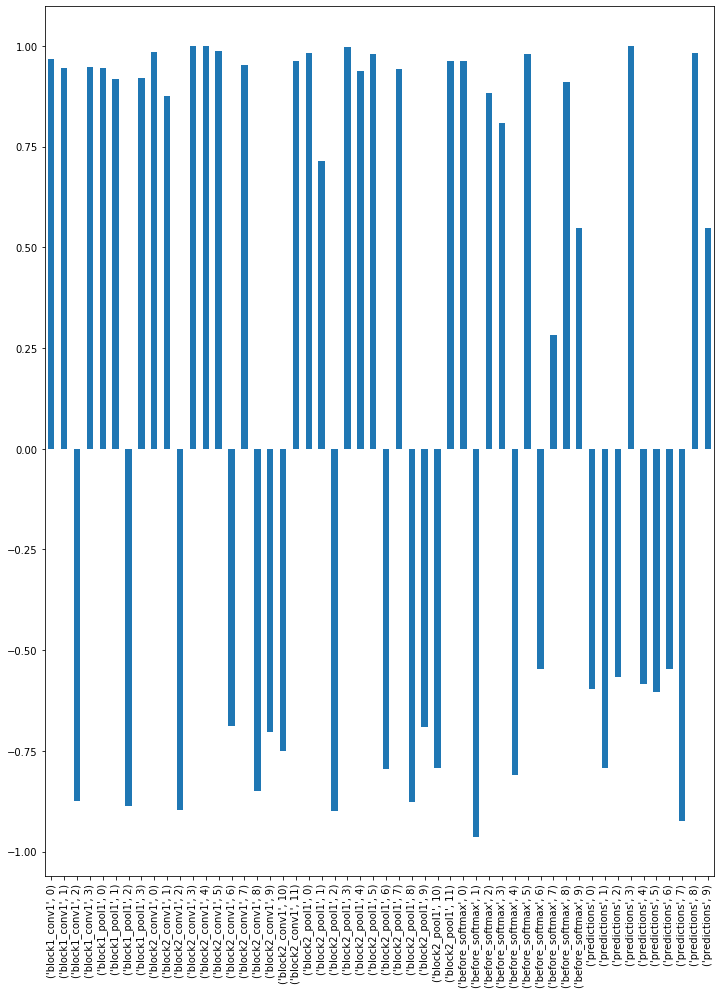

In [112]:
df_corr = df.corr()

#fig, axes = plt.subplots(figsize=(12, 16))
#df_corr[["('predictions', 3)","('before_softmax', 7)"]].plot(kind="bar")
fig, axes = plt.subplots(figsize=(12, 16))
df_corr["('predictions', 3)"].plot(kind="bar")

In [113]:
(df_corr["('predictions', 3)"] > 0.80)+(df_corr["('predictions', 3)"] < -0.80)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


('block1_conv1', 0)       True
('block1_conv1', 1)       True
('block1_conv1', 2)       True
('block1_conv1', 3)       True
('block1_pool1', 0)       True
('block1_pool1', 1)       True
('block1_pool1', 2)       True
('block1_pool1', 3)       True
('block2_conv1', 0)       True
('block2_conv1', 1)       True
('block2_conv1', 2)       True
('block2_conv1', 3)       True
('block2_conv1', 4)       True
('block2_conv1', 5)       True
('block2_conv1', 6)      False
('block2_conv1', 7)       True
('block2_conv1', 8)       True
('block2_conv1', 9)      False
('block2_conv1', 10)     False
('block2_conv1', 11)      True
('block2_pool1', 0)       True
('block2_pool1', 1)      False
('block2_pool1', 2)       True
('block2_pool1', 3)       True
('block2_pool1', 4)       True
('block2_pool1', 5)       True
('block2_pool1', 6)      False
('block2_pool1', 7)       True
('block2_pool1', 8)       True
('block2_pool1', 9)      False
('block2_pool1', 10)     False
('block2_pool1', 11)      True
('before